In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from routines.models import get_pipe_base
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.kernel_approximation import RBFSampler, Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from routines.models import get_balanced_sample_weights, ks_test_d, ks_test_p
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report, roc_auc_score, f1_score, log_loss
from time import time
from routines.transformers import SparseTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm as sp_norm
from routines.evals_n_plots import get_cv_res_df, plot_cv_res_df, plot_permut_hist, plot_learning_curve, \
    plot_multi_metric_cv, plot_confusion_matrix, plot_roc_curve, plot_prc_curve
from sklearn.model_selection import permutation_test_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ks_2samp
import pickle
from sklearn.calibration import CalibratedClassifierCV

### Set params

In [2]:
random_state: int = 42
sample_test_size: float = 0.20
max_jobs: int = -1
pre_dispatch = 8
outer_cv: int = 5
inner_cv: int = 3

### Load training set

In [3]:
df = pd.read_csv('src/Train_Sample.csv', sep=';', index_col=0)
y = df['Status']
X = df.drop(labels='Status', axis=1, inplace=False)
del df
print('X.shape: {0}\ty.shape: {1}'.format(X.shape, y.shape))

X.shape: (65974, 221)	y.shape: (65974,)


### Split training set into train-test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_test_size,
                                                    random_state=random_state,
                                                    stratify=y)
print('X_train.shape: {0}\ty_train.shape: {1}\n'
      'X_test.shape: {2}\ty_test.shape: {3}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (52779, 221)	y_train.shape: (52779,)
X_test.shape: (13195, 221)	y_test.shape: (13195,)



## Load base pipe (extract base features)

In [5]:
corr_threshold = 0.90
var_threshold = (0.98 * (1.00 - 0.98))

pipe_base = get_pipe_base(random_state=random_state, corr_threshold=corr_threshold, var_threshold=var_threshold)
# pipe_base

##Lets fit some LOGIT

In [6]:
matthews = make_scorer(matthews_corrcoef)
# ks_d = make_scorer(ks_test_d, greater_is_better=False)
# ks_p = make_scorer(ks_test_p, greater_is_better=True)
# f2 = make_scorer(fbeta_score, beta=2)
scorings = {'AUC': 'roc_auc', 'F1': 'f1', #'F2': f2,
            # 'ACC': 'accuracy', 'PRE': 'precision', 'REC': 'recall', 
            'MCC': matthews,
            '-LogLoss': 'neg_log_loss'
            # 'KSD': ks_d, 'KSP': ks_p,
            }
main_score = 'MCC'

In [7]:
pipe_pca_lrc = Pipeline(steps=[('pipe_base', pipe_base),
                               ('smote', SMOTE(ratio='auto',
                                               kind='regular',
                                               n_jobs=max_jobs,
                                               random_state=random_state)),
                               ('pca', PCA(n_components='mle',  # n_components=212,
                                           svd_solver='full',
                                           random_state=random_state)),
                               ('logistic', LogisticRegression(random_state=random_state,
                                                               n_jobs=max_jobs,
                                                               class_weight='balanced',
                                                               penalty='l2',
                                                               solver='lbfgs',
                                                               # solver='sag',  #'saga'
                                                               max_iter=1000,
                                                               C=29.0, )),
                               ],
                        # memory='pipe_cache/'
                        )
# pipe_pca_lrc.named_steps.smote

In [8]:
# param_dist = {'nystroem__gamma': sp_uniform(loc=0.01, scale=0.02),
#               'logistic__C': sp_randint(low=20, high=35)}
param_dist = {'logistic__C': np.linspace(25,35,10),
              #'nystroem__gamma': sp_uniform(loc=0.01, scale=0.02),
              }
# param_dist

In [9]:
n_iter_search = 10
rs = RandomizedSearchCV(estimator=pipe_pca_lrc,
                        param_distributions=param_dist,
                        n_iter=n_iter_search,
                        scoring=scorings,
                        refit=main_score,
                        return_train_score=True,
                        cv=inner_cv,
                        random_state=random_state,
                        n_jobs=max_jobs,
                        pre_dispatch=pre_dispatch, )

In [10]:
t0 = time()
rs.fit(X_train, y_train)
rs_best_estim = rs.best_estimator_
print('Fit Time: ', (time() - t0))
print(rs.best_params_)

Fit Time:  428.6841552257538
{'logistic__C': 25.0}


In [143]:
rs.best_params_

{'logistic__C': 27.222222222222221}

In [158]:
# [{k: rs.cv_results_[k]} for k in rs.cv_results_.keys() if 'rank_test_' in k or 'params' in k]

In [144]:
cv_res_df = get_cv_res_df(rs.cv_results_, rs.best_index_)
cv_res_df

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mean</th>
      <th colspan="2" halign="left">std</th>
    </tr>
    <tr>
      <th></th>
      <th>test</th>
      <th>train</th>
      <th>test</th>
      <th>train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>-LogLoss</th>
      <td>-0.4796</td>
      <td>-0.4727</td>
      <td>0.0015</td>
      <td>0.0009</td>
    </tr>
    <tr>
      <th>AUC</th>
      <td>0.8438</td>
      <td>0.8592</td>
      <td>0.0021</td>
      <td>0.0014</td>
    </tr>
    <tr>
      <th>F1</th>
      <td>0.3172</td>
      <td>0.3280</td>
      <td>0.0047</td>
      <td>0.0009</td>
    </tr>
    <tr>
      <th>MCC</th>
      <td>0.3056</td>
      <td>0.3225</td>
      <td>0.0061</td>
      <td>0.0017</td>
    </tr>
  </tbody>
</table>
</div>

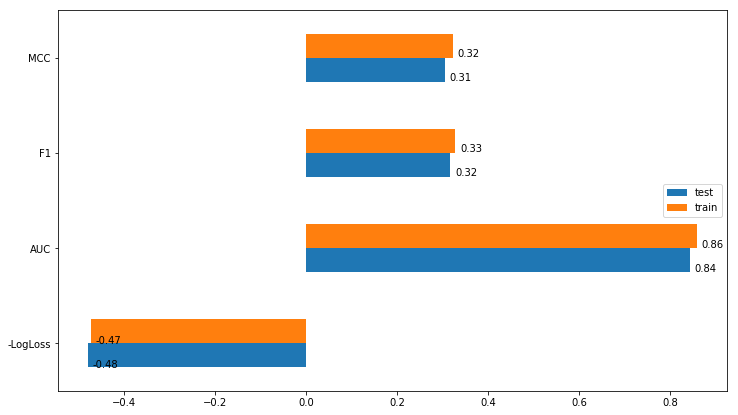

In [145]:
plot_cv_res_df(cv_res_df=cv_res_df, figsize=(12, 7))

In [19]:
n_permutations = 10
print('Best possible pvalue', 1 / (n_permutations + 1))

Best possible pvalue 0.09090909090909091


In [20]:
t0 = time()
score, permutation_scores, pvalue = permutation_test_score(rs_best_estim, X_test, y_test, 
                                                           scoring="roc_auc", 
                                                           cv=inner_cv,
                                                           n_permutations=n_permutations, 
                                                           n_jobs=max_jobs)
print('Fit Time: ', (time() - t0))

Fit Time:  135.17588591575623


<module 'matplotlib.pyplot' from 'C:\\Users\\Bogdan\\Downloads\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

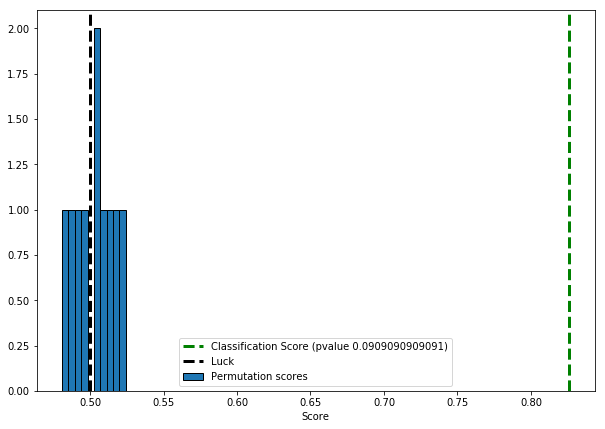

In [23]:
plot_permut_hist(permutation_scores=permutation_scores, score=score, pvalue=pvalue,
                 n_classes=2, bins=10, figsize=(10, 7))

In [147]:
t0 = time()
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(estimator=rs_best_estim, X=X_test, y=y_test,
                                                        cv=inner_cv, n_jobs=max_jobs, scoring='roc_auc',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  70.75722360610962


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

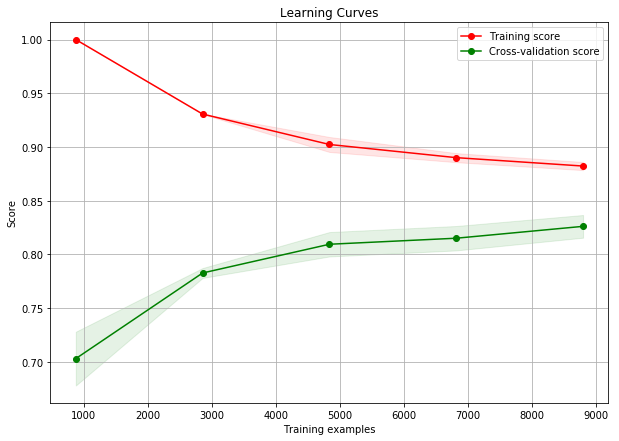

In [148]:
plot_learning_curve(train_sizes=train_sizes_lr, train_scores=train_scores_lr, test_scores=test_scores_lr,
                    title='Learning Curves', ylim=None, figsize=(10, 7))

####Refit

In [149]:
t0 = time()
rs_best_estim.fit(X_train, y_train)
print('Refit Time: ', (time() - t0))

Refit Time:  106.08478617668152


In [150]:
t0 = time()
pred_train = rs_best_estim.predict(X_train)
pred_test = rs_best_estim.predict(X_test)
proba_train = rs_best_estim.predict_proba(X_train)
proba_test = rs_best_estim.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  10.729263305664062


In [153]:
print('#TRAIN#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, pred_train),
                ks_2samp(y_train, pred_train)[0],
                ks_2samp(y_train, pred_train)[1],
                log_loss(y_train, proba_train[:, 1]), ))

print('\n#TEST#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, pred_test),
                ks_2samp(y_train, pred_test)[0],
                ks_2samp(y_train, pred_test)[1],
                log_loss(y_test, proba_test[:, 1]), ))

#TRAIN#
AUC: 0.8572136386267732
F1: 0.32347787998247923
MCC: 0.3175124603154477
KS: D=0.20390685689384036, p-value=0.0
Log Loss: 0.47707255527084214

#TEST#
AUC: 0.8505173406850061
F1: 0.3185457693140013
MCC: 0.3117644283039284
KS: D=0.2080509460035408, p-value=0.0
Log Loss: 0.49051018862798335


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

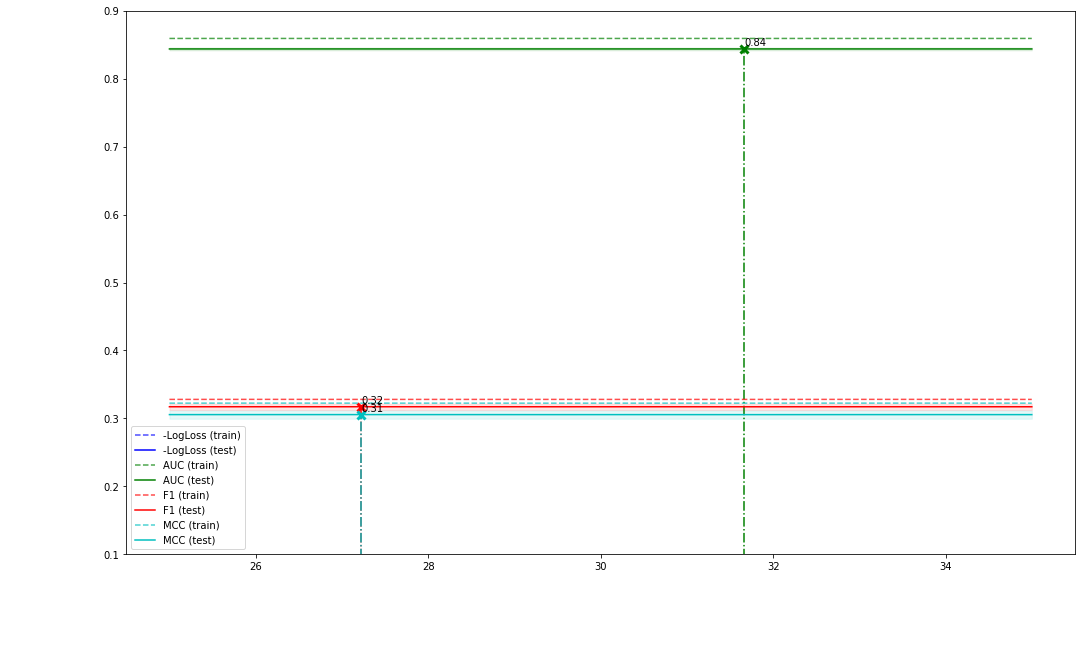

In [154]:
plot_multi_metric_cv(scorings=scorings, cv_results=rs.cv_results_, param_name='param_logistic__C', figsize=(17, 10))

Confusion matrix, without normalization
[[9312 2945]
 [ 202  736]]


<module 'matplotlib.pyplot' from 'C:\\Users\\Bogdan\\Downloads\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

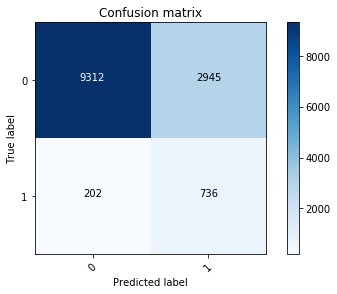

In [34]:
plot_confusion_matrix(y_test, pred_test, classes=[0, 1], normalize=False)

In [155]:
print(classification_report(y_test, pred_test))

             precision    recall  f1-score   support

          0       0.98      0.76      0.86     12257
          1       0.20      0.78      0.32       938

avg / total       0.92      0.76      0.82     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

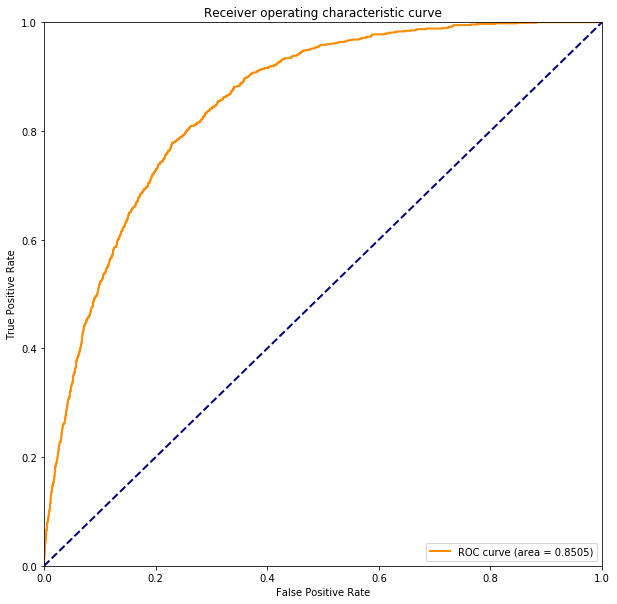

In [156]:
plot_roc_curve(target=y_test, proba=proba_test[:, 1], pos_label=1, figsize=(10, 10))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

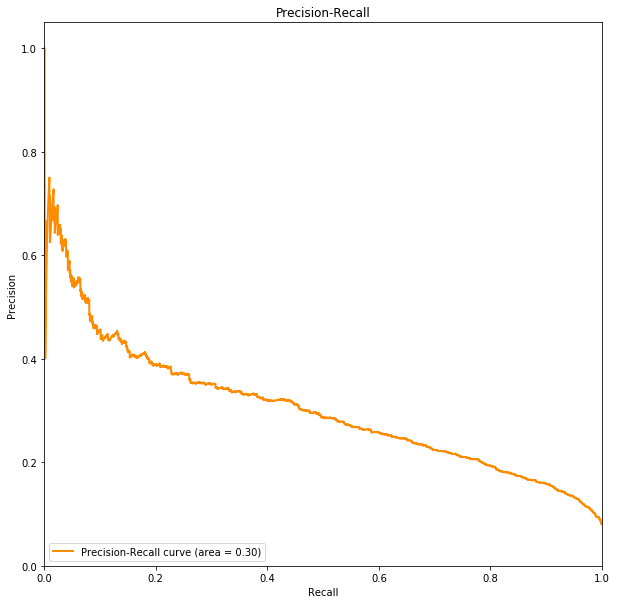

In [157]:
plot_prc_curve(target=y_test, proba=proba_test[:, 1], pos_label=1, average='macro', figsize=(10, 10))

In [44]:
# BSOD :(
# scores_lrc = cross_validate(estimator=rs_lrc, X=X_train, y=y_train,
#                             scoring=scoring2, cv=outer_cv,
#                             n_jobs=max_jobs, pre_dispatch=pre_dispatch, )

##Lets do some RandomForestClassifier

In [133]:
matthews2 = make_scorer(matthews_corrcoef)
scoring2 = {'AUC': 'roc_auc', 'F1': 'f1', 'MCC': matthews2, '-LogLoss': 'neg_log_loss'}
main_score2 = 'MCC'

In [117]:
pipe_rfc = Pipeline(steps=[('pipe_base', pipe_base),
                           ('smote', SMOTE(ratio='auto',
                                           kind='regular',
                                           n_jobs=max_jobs,
                                           random_state=random_state)),
                           # ('pca', PCA(n_components=0.8,  # n_components='mle',  n_components=212,
                           # svd_solver='full',
                           # random_state=random_state)),
                           ('random_forest', RandomForestClassifier(random_state=random_state,
                                                                    n_jobs=max_jobs,
                                                                    criterion='entropy',
                                                                    class_weight='balanced_subsample',
                                                                    bootstrap=True,
                                                                    oob_score=False,
                                                                    n_estimators=300,
                                                                    max_features='sqrt',
                                                                    max_depth=None,
                                                                    min_samples_leaf=1,
                                                                    min_impurity_decrease=0.0, )
                            ),
                           ],
                    # memory='pipe_cache/'
                    )
# pipe_rfc.named_steps.pca

In [118]:
param_dist_rfc = {'random_forest__min_impurity_decrease': np.linspace(0.005, 0.015, 10)
                  # sp_uniform(loc=0.00001, scale=0.02000) # np.linspace(0.00001, 0.02, 10)
                  # 'random_forest__max_depth': sp_randint(low=10, high=35),
                  # 'random_forest__max_features': sp_uniform(loc=0.10, scale=0.15),
                  # 'random_forest__min_samples_leaf': sp_uniform(loc=0.001, scale=0.029),
                  }

In [119]:
# rs_rfc = pipe_rfc

n_iter_search = 10
rs_rfc = RandomizedSearchCV(estimator=pipe_rfc,
                            param_distributions=param_dist_rfc,
                            n_iter=n_iter_search,
                            scoring=scoring2,
                            refit=main_score2,
                            return_train_score=True,
                            cv=inner_cv,
                            random_state=random_state,
                            n_jobs=max_jobs,
                            pre_dispatch=pre_dispatch, )

In [120]:
t0 = time()
rs_rfc.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))
rs_rfc_best_estim = rs_rfc.best_estimator_
print(rs_rfc.best_params_)

Fit Time:  991.3947746753693
{'random_forest__min_impurity_decrease': 0.0094444444444444428}


In [121]:
rs_rfc_best_estim = rs_rfc.best_estimator_
rs_rfc.best_params_

{'random_forest__min_impurity_decrease': 0.0094444444444444428}

In [122]:
rs_rfc_res_df = get_cv_res_df(rs_rfc.cv_results_, rs_rfc.best_index_)
rs_rfc_res_df

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mean</th>
      <th colspan="2" halign="left">std</th>
    </tr>
    <tr>
      <th></th>
      <th>test</th>
      <th>train</th>
      <th>test</th>
      <th>train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>-LogLoss</th>
      <td>-0.4658</td>
      <td>-0.4649</td>
      <td>0.0036</td>
      <td>0.0042</td>
    </tr>
    <tr>
      <th>AUC</th>
      <td>0.8151</td>
      <td>0.8202</td>
      <td>0.0041</td>
      <td>0.0018</td>
    </tr>
    <tr>
      <th>F1</th>
      <td>0.3278</td>
      <td>0.3305</td>
      <td>0.0042</td>
      <td>0.0025</td>
    </tr>
    <tr>
      <th>MCC</th>
      <td>0.2805</td>
      <td>0.2841</td>
      <td>0.0053</td>
      <td>0.0027</td>
    </tr>
  </tbody>
</table>
</div>

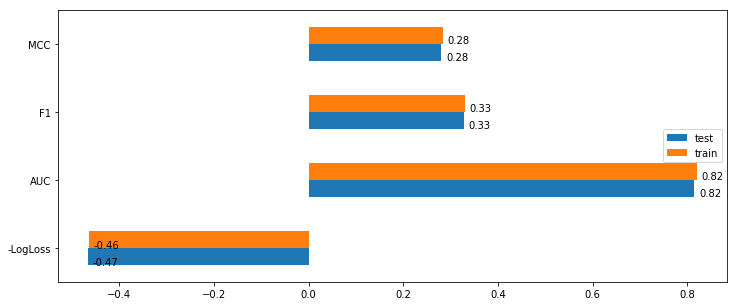

In [123]:
plot_cv_res_df(cv_res_df=rs_rfc_res_df, figsize=(12, 5))

In [124]:
t0 = time()
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(estimator=rs_rfc_best_estim, X=X_test, y=y_test,
                                                                 cv=inner_cv, n_jobs=max_jobs, scoring='roc_auc',
                                                                 train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  59.389089822769165


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

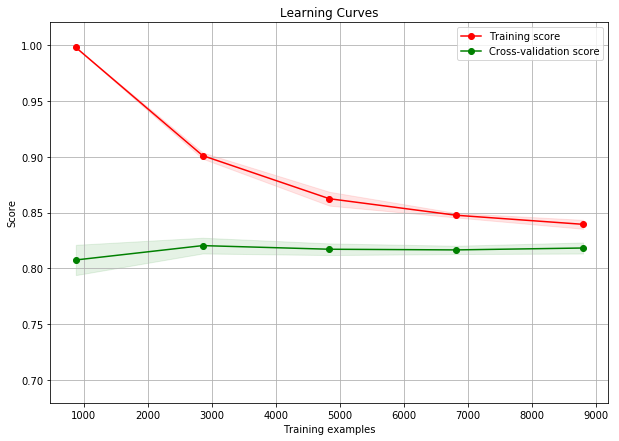

In [125]:
plot_learning_curve(train_sizes=train_sizes_rf, train_scores=train_scores_rf, test_scores=test_scores_rf,
                    title='Learning Curves', ylim=(0.68, 1.02), figsize=(10, 7))

####Refit

In [126]:
t0 = time()
rs_rfc_best_estim.fit(X_train, y_train)
print('Refit Time: ', (time() - t0))

Refit Time:  59.176961183547974


In [127]:
t0 = time()
rfc_pred_train = rs_rfc_best_estim.predict(X_train)
rfc_pred_test = rs_rfc_best_estim.predict(X_test)
rfc_proba_train = rs_rfc_best_estim.predict_proba(X_train)
rfc_proba_test = rs_rfc_best_estim.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  12.204983472824097


In [128]:
print('#TRAIN#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, rfc_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=rfc_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, rfc_pred_train),
                ks_2samp(y_train, rfc_pred_train)[0],
                ks_2samp(y_train, rfc_pred_train)[1],
                log_loss(y_train, rfc_proba_train[:, 1]), ))

print('\n#TEST#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, rfc_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=rfc_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, rfc_pred_test),
                ks_2samp(y_train, rfc_pred_test)[0],
                ks_2samp(y_train, rfc_pred_test)[1],
                log_loss(y_test, rfc_proba_test[:, 1]), ))

#TRAIN#
AUC: 0.8179448956930949
F1: 0.3281649616368287
MCC: 0.283476969581077
KS: D=0.09492411754675156, p-value=2.8622341543736064e-207

#TEST#
AUC: 0.812879651208404
F1: 0.3192019950124688
MCC: 0.273995173371306
KS: D=0.10096492857269579, p-value=4.118462612597852e-94


In [129]:
print(classification_report(y_test, rfc_pred_test))

             precision    recall  f1-score   support

          0       0.96      0.86      0.91     12257
          1       0.23      0.55      0.32       938

avg / total       0.91      0.83      0.86     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

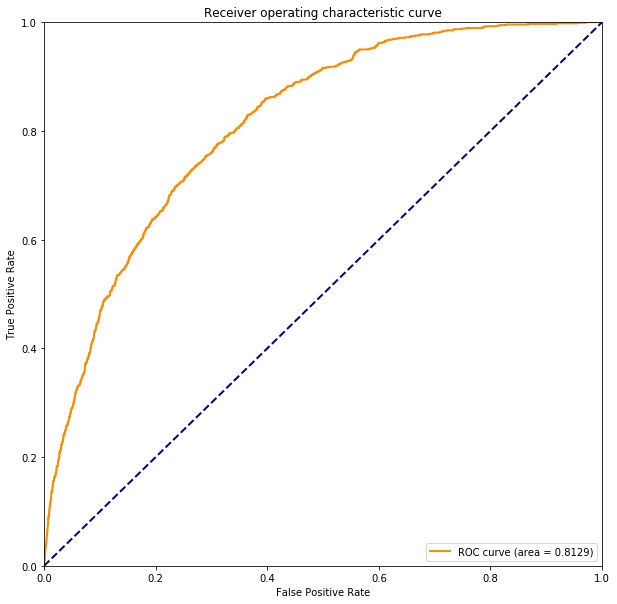

In [130]:
plot_roc_curve(target=y_test, proba=rfc_proba_test[:, 1], pos_label=1, figsize=(10, 10))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

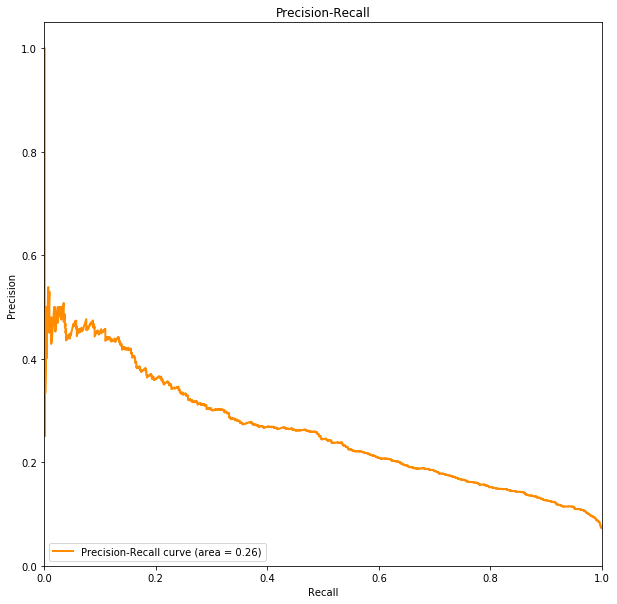

In [131]:
plot_prc_curve(target=y_test, proba=rfc_proba_test[:, 1], pos_label=1, average='macro', figsize=(10, 10))